# Dataset Deret Waktu untuk Prediksi
Pengambilan Data NO₂ Sentinel-5P Wilayah Bangkalan melalui openEO

Kode berikut digunakan untuk memperoleh data konsentrasi Nitrogen Dioksida (NO₂) dari satelit Sentinel-5P menggunakan platform openEO. Dataset ini dimanfaatkan untuk menganalisis kualitas udara berdasarkan dimensi waktu dan lokasi tertentu.

Langkah-langkah prosesnya meliputi:

1. Autentikasi ke openEO
Proses ini dilakukan untuk memperoleh akses terhadap dataset Sentinel-5P melalui endpoint openeo.dataspace.copernicus.eu menggunakan metode autentikasi OIDC.

2. Penentuan Area of Interest (AOI)
AOI ditetapkan dalam bentuk poligon dengan koordinat lintang dan bujur yang menggambarkan area penelitian di wilayah Bangkalan.

3. Pemanggilan Koleksi Data Sentinel-5P
Koleksi data SENTINEL_5P_L2 dimuat berdasarkan rentang waktu tertentu (tanggal awal hingga akhir) serta menggunakan bounding box yang sedikit lebih luas dari AOI guna menghindari kesalahan akibat resolusi spasial Sentinel-5P yang sekitar 7 km.

4. Agregasi Temporal (Rata-rata Harian)
Karena observasi Sentinel-5P dapat terjadi beberapa kali dalam sehari, maka dilakukan perhitungan rata-rata harian untuk mendapatkan satu nilai representatif per hari.

5. Agregasi Spasial Berdasarkan AOI
Nilai rata-rata konsentrasi NO₂ dihitung hanya pada area yang termasuk dalam AOI yang telah didefinisikan sebelumnya.

6. Eksekusi Batch dan Penyimpanan Data
Seluruh proses dijalankan sebagai batch job di server, dan hasil akhirnya disimpan dalam format NetCDF (.nc) agar dapat digunakan untuk analisis lanjutan.

In [ ]:
import openeo

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

aoi = {
    "type": "Polygon",
        "coordinates": [
        [
            [
                112.76,
                -7.021
            ],
            [
                112.74,
                -7.021
            ],
            [
                112.74,
                -7.035
            ],
            [
                112.76,
                -7.035
            ],
            [
                112.76,
                -7.021
            ]
        ]
    ],
    "type": "Polygon"
}

s5p_no2 = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2023-10-15", "2025-10-19"],
    spatial_extent={
        "west": 112.60,
        "south": -7.10,
        "east": 112.90,
        "north": -6.90
    },
    bands=["NO2"]
)

# 4. Hitung rata-rata harian
s5p_no2_daily = s5p_no2.aggregate_temporal_period(
    period="day",
    reducer="mean"
)

# 5. Hitung rata-rata spasial berdasarkan AOI
s5p_no2_aoi = s5p_no2_daily.aggregate_spatial(
    geometries=aoi,
    reducer="mean"
)

job = s5p_no2.execute_batch(title="NO2 in bangkalan", outputfile="NO2_in_bangkalan.nc")

# Membaca Data NetCDF dan Mengekstrak Variabel NO₂

Setelah proses pengambilan data dari openEO selesai dan hasilnya disimpan dalam file NO2_in_bangkalan.nc, tahap berikutnya adalah membuka file tersebut untuk meninjau isi serta mengekstrak variabel yang relevan.

Format NetCDF (.nc) merupakan format standar yang digunakan untuk menyimpan data iklim dan pengamatan satelit karena mampu menangani data berdimensi jamak, seperti dimensi ruang dan waktu. Untuk mengakses isi file ini, digunakan pustaka netCDF4.

Langkah-langkah utama yang dilakukan meliputi:

1. Membuka file .nc menggunakan netCDF4.Dataset
File dibuka sebagai objek dataset sehingga seluruh isinya dapat diakses secara langsung.

2. Menampilkan daftar variabel dalam dataset
Langkah ini dilakukan untuk mengetahui variabel apa saja yang tersedia, termasuk nama variabel konsentrasi NO₂ serta variabel waktu (biasanya bernama "time" atau "t").

3. Mengambil data NO₂ dan waktu
Data NO₂ diakses dalam bentuk array multi-dimensi, sementara variabel waktu biasanya disimpan dalam bentuk offset numerik, misalnya “days since 1970-01-01”.

4. Mengonversi format waktu ke tanggal sebenarnya
Dengan memanfaatkan atribut units pada metadata waktu, nilai offset dapat diubah menjadi format tanggal (datetime).

5. Menampilkan cuplikan data
Sebagai langkah verifikasi, beberapa nilai pertama dari data NO₂ ditampilkan untuk memastikan bahwa proses pembacaan berjalan dengan benar.

In [ ]:
import netCDF4

file_path = "costs/NO2_in_bangkalan.nc"
ds = netCDF4.Dataset(file_path)

# Lihat seluruh variabel yang tersedia
print("📦 Variabel dalam file:")
print(ds.variables.keys())

# Misal variabel utama bernama "NO2"
no2 = ds.variables["NO2"][:]

# Waktu (biasanya dalam format 'days since ...' atau sejenis)
time = ds.variables["t"][:]

# Konversi waktu ke format tanggal jika punya atribut 'units'
try:
    time_units = ds.variables["t"].units
    dates = netCDF4.num2date(time, units=time_units)
except Exception:
    dates = time  # fallback kalau tidak ada units

# Tampilkan 10 baris pertama
print("\n📅 Contoh data pertama:")
for i in range(min(10, len(no2))):
    print(f"{dates[i]} | NO2: {no2[i]}")

# Konversi Data NetCDF ke CSV untuk Analisis Lanjutan

Data hasil unduhan dari openEO disimpan dalam format NetCDF (.nc), yaitu format standar yang umum digunakan untuk menyimpan data penginderaan jauh serta data sains kebumian. Namun, agar data tersebut lebih mudah dianalisis secara statistik atau divisualisasikan secara sederhana (misalnya menggunakan Excel atau pustaka Pandas), file NetCDF perlu dikonversi terlebih dahulu ke format CSV yang lebih umum dan mudah diolah.

In [ ]:
import netCDF4
import pandas as pd
import numpy as np

# 1. Baca file NetCDF
file_path = "costs/NO2_in_bangkalan.nc"
ds = netCDF4.Dataset(file_path)

# 2. Tampilkan struktur file
print(ds)

# 3. Ambil variabel yang tersedia
print(ds.variables.keys())

# 4. Ambil variabel waktu dan NO2
time_var = ds.variables["t"][:]
no2_var = ds.variables["NO2"][:]

# 5. Konversi waktu ke datetime
time_units = ds.variables["t"].units
dates = netCDF4.num2date(time_var, units=time_units)

# 6. Jika data NO2 berdimensi lebih dari 1 (misalnya [time, lat, lon]),
# kita rata-ratakan agar menjadi satu nilai per waktu
if no2_var.ndim > 1:
    no2_mean = np.nanmean(no2_var, axis=tuple(range(1, no2_var.ndim)))
else:
    no2_mean = no2_var

# 7. Buat DataFrame
df = pd.DataFrame({
    "time": dates,
    "NO2": no2_mean
})

# 8. Simpan ke CSV
df.to_csv("costs/NO2_bangkalan.csv", index=False)
print("✅ File NO2_bangkalan.csv berhasil dibuat.")
print(df.head())

# Transformasi Data NO₂ ke Format Supervised Learning

Setelah data konsentrasi NO₂ dikonversi ke dalam format CSV, langkah berikutnya adalah melakukan proses transformasi agar data siap digunakan dalam pemodelan deret waktu (time series). Tahap ini penting terutama untuk penerapan model berbasis supervised learning, seperti LSTM, GRU, maupun model hibrida ARIMA.

In [ ]:
import pandas as pd

df = pd.read_csv("/content/sample_data/NO2_bangkalan.csv")

df['time'] = pd.to_datetime(df['time'], errors='coerce')

df = df.set_index('time')

df['NO2'] = df['NO2'].interpolate(method='time')

print(df.isna().sum())

n_lags = 4

supervised = pd.DataFrame()

for i in range(n_lags, 0, -1):
    supervised[f'NO2(t-{i})'] = df['NO2'].shift(i)

supervised['NO2(t)'] = df['NO2']

# drop NaN value
supervised = supervised.dropna()

print("📅 Head of Data:")
print(supervised.head())

print("")
print("📦 Data info:")
supervised.info

NO2    0
dtype: int64
📅 Head of Data:
            NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
time                                                        
2023-10-19  0.000024  0.000025  0.000032  0.000027  0.000027
2023-10-20  0.000025  0.000032  0.000027  0.000027  0.000024
2023-10-21  0.000032  0.000027  0.000027  0.000024  0.000033
2023-10-22  0.000027  0.000027  0.000024  0.000033  0.000030
2023-10-23  0.000027  0.000024  0.000033  0.000030  0.000031

📦 Data info:


<bound method DataFrame.info of             NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
time                                                        
2023-10-19  0.000024  0.000025  0.000032  0.000027  0.000027
2023-10-20  0.000025  0.000032  0.000027  0.000027  0.000024
2023-10-21  0.000032  0.000027  0.000027  0.000024  0.000033
2023-10-22  0.000027  0.000027  0.000024  0.000033  0.000030
2023-10-23  0.000027  0.000024  0.000033  0.000030  0.000031
...              ...       ...       ...       ...       ...
2025-10-14  0.000034  0.000016  0.000024  0.000024  0.000025
2025-10-15  0.000016  0.000024  0.000024  0.000025  0.000026
2025-10-16  0.000024  0.000024  0.000025  0.000026  0.000028
2025-10-17  0.000024  0.000025  0.000026  0.000028  0.000028
2025-10-18  0.000025  0.000026  0.000028  0.000028  0.000026

[725 rows x 5 columns]>

# Normalisasi Data untuk Model Berbasis Supervised Learning

Setelah data deret waktu NO₂ diubah ke dalam format supervised (dengan penambahan variabel lag), tahap selanjutnya adalah melakukan proses normalisasi menggunakan metode Min-Max Scaling. Tujuan dari langkah ini adalah untuk menyamakan skala seluruh fitur sehingga nilai input model berada dalam rentang [0, 1].

Model deret waktu modern seperti LSTM dan GRU sangat peka terhadap perbedaan skala antarvariabel. Oleh karena itu, normalisasi menjadi langkah krusial guna meningkatkan kestabilan proses pelatihan serta akurasi prediksi yang dihasilkan.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Pisahkan fitur dan target
X = supervised[['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']]
y = supervised['NO2(t)']

# Normalisasi Min-Max
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Ubah index time jadi kolom lagi
supervised = supervised.reset_index()

# Konversi kembali ke Dataframe
normalized_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Sebelum normalisasi:\n", X.head())
print("\nSesudah normalisasi:\n", normalized_df.head())

Sebelum normalisasi:
             NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)
time                                              
2023-10-19  0.000024  0.000025  0.000032  0.000027
2023-10-20  0.000025  0.000032  0.000027  0.000027
2023-10-21  0.000032  0.000027  0.000027  0.000024
2023-10-22  0.000027  0.000027  0.000024  0.000033
2023-10-23  0.000027  0.000024  0.000033  0.000030

Sesudah normalisasi:
    NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)
0  0.190821  0.195279  0.242227  0.206855
1  0.195279  0.242227  0.206855  0.207072
2  0.242227  0.206855  0.207072  0.187033
3  0.206855  0.207072  0.187033  0.251459
4  0.207072  0.187033  0.251459  0.234280


# Pemodelan Deret Waktu NO₂ dengan K-Nearest Neighbors (KNN) Regressor

Setelah data NO₂ melalui proses normalisasi dan diubah menjadi format supervised learning, tahap selanjutnya adalah membangun model machine learning untuk melakukan prediksi deret waktu. Pada tahap ini digunakan K-Nearest Neighbors Regressor (KNN) sebagai model dasar (baseline model) sebelum dilakukan pengujian dengan model berbasis deep learning seperti LSTM atau GRU.

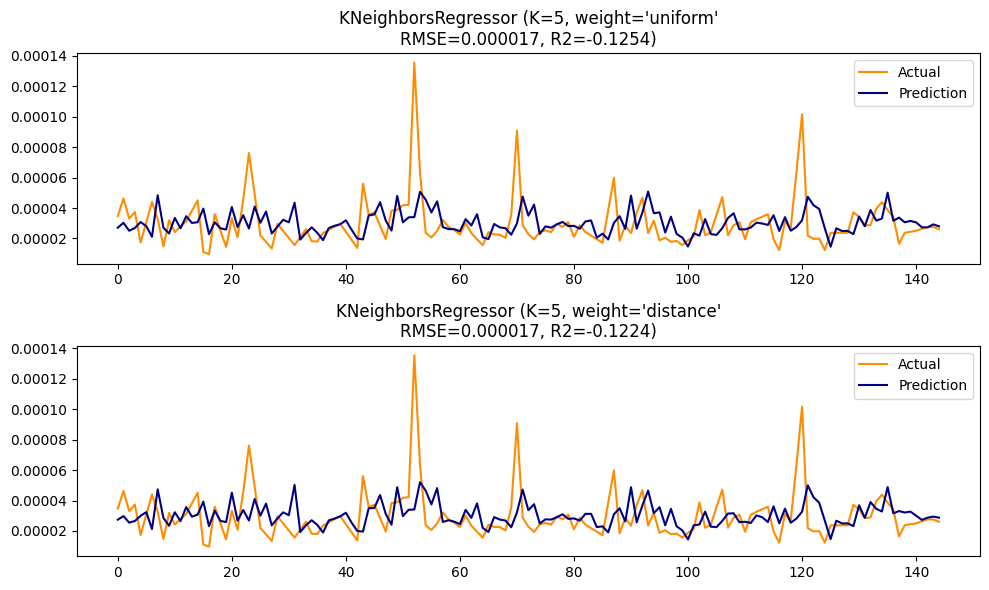

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = supervised[['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']]
y = supervised['NO2(t)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

n_neighbors = 5

plt.figure(figsize=(10, 6))

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    plt.subplot(2, 1, i + 1)
    plt.plot(range(len(y_test)), y_test, 'darkorange', label="Actual")
    plt.plot(range(len(y_pred)), y_pred, 'navy', label="Prediction")
    plt.title(f"KNeighborsRegressor (K={n_neighbors}, weight='{weights}'\nRMSE={rmse:.6f}, R2={r2:.4f})")
    plt.legend()
    plt.tight_layout()

plt.show()